# Load dependencies and tables

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown as md

In [3]:
output_tables = "output_tables"
run_dir_name = input(f"Enter the directory name of the ZOTU tables in the {output_tables} directory")
run_dir = os.path.join(output_tables, run_dir_name)

df_sample_mapping = pd.read_csv(os.path.join(output_tables, "sample_mapping.csv"))

df_filter_mapping_full = pd.read_csv(os.path.join(run_dir, "filter_mapping_full.csv"))
df_filter_mapping = pd.read_csv(os.path.join(run_dir, "filter_mapping.csv"))
df_truncate_mapping = pd.read_csv(os.path.join(run_dir, "truncate_mapping.csv"))

df_refseq_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full.csv"))
df_refseq = pd.read_csv(os.path.join(run_dir, "refseq_table_pk.csv"))

df_refseq_srr_mapping_full = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr_full.csv"))
df_refseq_srr_mapping = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr.csv"))

# Length of ZOTUs

,refseq_length
count,1523.000000
mean,315.577150
std,31.713709
min,204.000000
25%,296.000000
50%,306.000000
75%,326.000000
max,450.000000


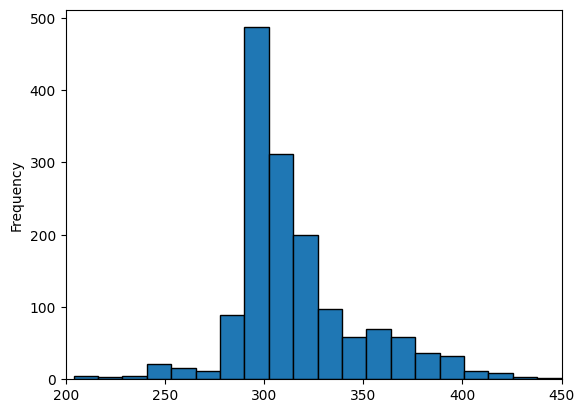

In [119]:
# Length of derep ZOTUs

display(df_refseq_full.describe())
df_refseq_full['refseq_length'].plot.hist(bins=20, xlim=(200, 450), edgecolor = "black")
plt.show()


# Filter results

In [131]:
# Merged table for analyzing filter results
display(md("## Merged table for analyzing filter results"))
df = df_truncate_mapping
df = df.merge(df_filter_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_filter_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}), on=["srr_name", "trunc_zotu_id"],
              suffixes=("_full", "_trunc"), how="left")
display(df.describe())

#Filter results on full length ZOTUs
df_filter = df[['passed_abun_full', 'passed_contam_full']]
df_filter_counts = pd.DataFrame.join(df_filter.value_counts(), df_filter.value_counts(normalize=True))
df_filter_counts.loc[(True,""),:] = df_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on full length ZOTUs"))
display(md(f"Of all {df_filter.shape[0]} full length ZOTUs found across all samples:"))
display(df_filter_counts)
display(md(f"- {df_filter_counts.loc[(True, '')]['count']} passed the abundance filter\n"
           f"- {df_filter_counts.loc[(True, True)]['count']} passed the contamination filter"))

# Truncation results on full length ZOTUs
df_trunc = df[df["passed_trunc"] == True]
df_trunc_derep = df_trunc.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])
df_trunc_counts = pd.DataFrame.join(
    df.value_counts(subset="passed_trunc"),
    df.value_counts(subset="passed_trunc", normalize=True))
df_trunc_counts = df_trunc_counts.join(
    df_trunc_derep.value_counts(subset="passed_trunc"), rsuffix=" derep")
display(md("## Truncation results on full length ZOTUs"))
display(md(f"Of all {df_filter.shape[0]} full length ZOTUs found across all samples:"))
display(df_trunc_counts)
display(md(f"- {df_trunc_counts.loc[True]['count']} passed truncation\n"
           f"\t- resulting in {df_trunc_counts.loc[True]['count derep']} after dereplication within samples\n"
           f"- {df_trunc_counts.loc[False]['count']} did not pass truncation (<250bp) and are discarded"))

# Filter results on discarded ZOTUs
df_not_trunc_filter = df[df["passed_trunc"] == False][['passed_abun_full', 'passed_contam_full']]
df_not_trunc_filter_counts = pd.DataFrame.join(df_not_trunc_filter.value_counts(), df_not_trunc_filter.value_counts(normalize=True))
df_not_trunc_filter_counts.loc[(True,""),:] = df_not_trunc_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on discarded ZOTUs"))
display(md(f"Of the {df_not_trunc_filter.shape[0]} full length ZOTUs that do not pass truncation (<250bp):"))
display(df_not_trunc_filter_counts)
display(md(f"- {df_not_trunc_filter_counts.loc[(True, '')]['count']} would have passed the abundance filter without truncation\n"
           f"- {df_not_trunc_filter_counts.loc[(True, True)]['count']} would have passed the contamination filter without truncation"))

# Filter results on truncated ZOTUs
df_trunc_filter_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True))
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']), rsuffix=" derep")
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True), rsuffix=" derep")
df_trunc_filter_counts.loc[(True,""),:] = df_trunc_filter_counts.loc[(True, slice(None))][['count', 'proportion', 'count derep', 'proportion derep']].sum()
display(md("## Filter results on truncated ZOTUs"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_trunc_filter_counts)
display(md(f"- {df_trunc_filter_counts.loc[(True, '')]['count']} passed the abundance filter\n"
           f"\t- resulting in {df_trunc_filter_counts.loc[(True, '')]['count derep']} after dereplication within samples\n"
           f"- {df_trunc_filter_counts.loc[(True, True)]['count']} passed the contamination filter\n"
           f"\t- resulting in {df_trunc_filter_counts.loc[(True, True)]['count derep']} after dereplication within samples"))

# Comparing filter results before and after truncation
df_abun_compare_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc'], normalize=True))
df_abun_compare_counts = df_abun_compare_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc']), rsuffix=" derep")
df_abun_compare_counts.loc[(False,True,"",""),:] = df_abun_compare_counts.loc[(False, True, slice(None), slice(None))][['count', 'proportion', 'count derep']].sum()
display(md("## Comparing filter results before and after truncation"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_abun_compare_counts)
display(md(f"- {df_abun_compare_counts.loc[(False, True, '', '')]['count']} passed the abundance filter only when truncated\n"
           f"\t- resulting in {df_abun_compare_counts.loc[(False, True, '', '')]['count derep']} after dereplication within samples\n"
           f"- {df_abun_compare_counts.loc[(slice(None), slice(None), False, True)]['count'].sum()} passed the contamination filter only when truncated\n (only because they would not have passed the abundance filter at full length)\n"
           f"\t- resulting in {df_abun_compare_counts.loc[(slice(None), slice(None), False, True)]['count derep'].sum()} after dereplication within samples\n"
           "- None no longer pass the contamination filter after truncation when they would have passed at full length"))



df_new_abun = df[(df['passed_abun_full'] == False) & (df['passed_abun_trunc'] == True)][['srr_name', 'trunc_zotu_id']]
df_new_abun = df_new_abun.merge(df_trunc_derep[df_trunc_derep['passed_abun_full'] == True][['srr_name', 'trunc_zotu_id']], how='left', indicator=True)
df_new_abun['new_zotu'] = df_new_abun['_merge'] == 'left_only'
df_new_abun = df_new_abun.drop(columns=['_merge'])
df_new_abun_counts = pd.DataFrame.join(
    df_new_abun.value_counts(subset=['new_zotu']),
    df_new_abun.drop_duplicates().value_counts(subset=['new_zotu']), rsuffix=" derep")
display(df_new_abun_counts)
#display(df_new_abun.groupby(['srr_name', 'trunc_zotu_id']).size())


## Merged table for analyzing filter results

,srr_name,zotu_id,trunc_zotu_id,passed_trunc,passed_abun_full,passed_contam_full,passed_abun_trunc,passed_contam_trunc
count,65596,65596,64280,65596,65596,65596,64280,64280
unique,190,868,855,2,2,2,2,2
top,NBCLAB4208,Zotu1,Zotu18,True,False,False,False,False
freq,868,190,202,64280,59472,60479,57653,58876


## Filter results on full length ZOTUs

Of all 65596 full length ZOTUs found across all samples:

count  proportion
passed_abun_full passed_contam_full                     
False            False               59472.0    0.906641
True             True                 5117.0    0.078008
                 False                1007.0    0.015352
                                      6124.0    0.093359

- 6124.0 passed the abundance filter
- 5117.0 passed the contamination filter

## Truncation results on full length ZOTUs

Of all 65596 full length ZOTUs found across all samples:

,count,proportion,count derep
passed_trunc,,,
True,64280,0.979938,61373.0
False,1316,0.020062,NaN


- 64280.0 passed truncation
	- resulting in 61373.0 after dereplication within samples
- 1316.0 did not pass truncation (<250bp) and are discarded

## Filter results on discarded ZOTUs

Of the 1316 full length ZOTUs that do not pass truncation (<250bp):

count  proportion
passed_abun_full passed_contam_full                    
False            False               1254.0    0.952888
True             True                  44.0    0.033435
                 False                 18.0    0.013678
                                       62.0    0.047112

- 62.0 would have passed the abundance filter without truncation
- 44.0 would have passed the contamination filter without truncation

## Filter results on truncated ZOTUs

Of all 64280 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  proportion  count derep  \
passed_abun_trunc passed_contam_trunc                                     
False             False                57653.0    0.896904      55247.0   
True              True                  5404.0    0.084070       5129.0   
                  False                 1223.0    0.019026        997.0   
                                        6627.0    0.103096       6126.0   

                                       proportion derep  
passed_abun_trunc passed_contam_trunc                    
False             False                        0.900184  
True              True                         0.083571  
                  False                        0.016245  
                                               0.099816

- 6627.0 passed the abundance filter
	- resulting in 6126.0 after dereplication within samples
- 5404.0 passed the contamination filter
	- resulting in 5129.0 after dereplication within samples

## Comparing filter results before and after truncation

Of all 64280 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  \
passed_abun_full passed_abun_trunc passed_contam_full passed_contam_trunc            
False            False             False              False                57653.0   
True             True              True               True                  5073.0   
                                   False              False                  989.0   
False            True              False              True                   331.0   
                                                      False                  234.0   
                                                                             565.0   

                                                                           proportion  \
passed_abun_full passed_abun_trunc passed_contam_full passed_contam_trunc               
False            False             False              False                  0.896904   
True             True              True               True                   0.078920   
                                   False              False                  0.015386   
False            True              False              True                   0.005149   
                                                      False                  0.003640   
                                                                             0.008790   

                                                                           count derep  
passed_abun_full passed_abun_trunc passed_contam_full passed_contam_trunc               
False            False             False              False                    55247.0  
True             True              True               True                      5024.0  
                                   False              False                      938.0  
False            True              False              True                       105.0  
                                                      False                       59.0  
                                                                                 164.0

- 565.0 passed the abundance filter only when truncated
	- resulting in 164.0 after dereplication within samples
- 331.0 passed the contamination filter only when truncated
 (only because they would not have passed the abundance filter at full length)
	- resulting in 105.0 after dereplication within samples
- None no longer pass the contamination filter after truncation when they would have passed at full length

,count,count derep
new_zotu,,
False,286,230
True,279,164
